In [82]:
import pandas as pd
import numpy as np

In [83]:
df_in = pd.read_csv('data/mhyph.txt', encoding = 'latin-1', header = None, names = ['words'])
df_in.head()

,words
0,a cap¥pel¥la
1,a for¥ti¥o¥ri
2,a go¥go
3,a pos¥te¥ri¥o¥ri
4,a pri¥o¥ri


In [121]:
def split_or_nan(x):
    import re
    try:
        return re.sub('¥$', '', re.sub('¥¥+', '¥', re.sub('[^¥a-zA-Z0-9 ]', '', x))).split()
    except:
        return np.nan

In [123]:
df_in['lists'] = df_in['words'].apply(split_or_nan)
df_in.dropna(inplace = True)
df_in.head()

,words,lists
0,a cap¥pel¥la,"[a, cap¥pel¥la]"
1,a for¥ti¥o¥ri,"[a, for¥ti¥o¥ri]"
2,a go¥go,"[a, go¥go]"
3,a pos¥te¥ri¥o¥ri,"[a, pos¥te¥ri¥o¥ri]"
4,a pri¥o¥ri,"[a, pri¥o¥ri]"


In [124]:
vocab = list({word for l in df_in['lists'] for word in l})
vocab[4407]

'trit¥an¥o¥pi¥a'

In [125]:
def word2bits(word):
    import re
    import numpy as np
    idxs = [m.start() for m in re.finditer(r'[^a-zA-Z0-9 ].', word)]
    arr = np.zeros(len(word) - len(idxs), dtype = np.int32)
    arr[0] = 1
    for i, idx in enumerate(idxs):
        arr[idx - i] = 1
    bits = ''.join([str(i) for i in arr])
    return bits

def count_syls(word):
    import re
    return len(re.findall(r'[^a-zA-Z0-9 ]', word)) + 1

def clean_text(word):
    import re
    return re.sub(r'[^a-zA-Z0-9 ]', '', word).lower()

In [126]:
df_out = pd.DataFrame()
df_out['words'] = list(map(clean_text, vocab))
df_out['syl_seq'] = list(map(word2bits, vocab))
df_out['syls'] = list(map(count_syls, vocab))
df_out.head()

,words,syl_seq,syls
0,nonindexed,1001010000,3
1,triforiforia,100101010101,6
2,grinning,10001000,2
3,suds,1000,1
4,prostate,10001000,2


In [127]:
[i for i in range(len(df_out)) if len(df_out['words'][i]) != len(df_out['syl_seq'][i])]

[]

In [128]:
df_out.to_csv('data/gutsyls.tsv', sep = '\t', encoding = 'utf-8', index = None)

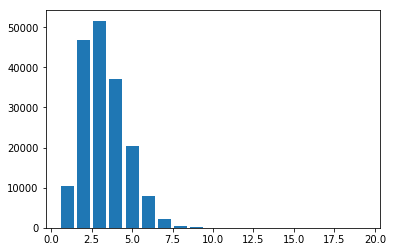

In [129]:
import matplotlib.pyplot as plt
counts = df_out['syls'].value_counts().sort_index()
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
plt.show()